## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Apr 07 03:19:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 39%   34C    P8    18W / 250W |    288MiB /  4096MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
import keras.backend as K

def focal_loss(y_true, y_pred,gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def cross_entropy(y_true, y_pred):         
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
           
    entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred)
    return tf.reduce_mean(entropy)

def combined_loss(W1=0.3,W2=0.7):    
    def combined_loss_fixed(y_true,y_pred):
        f_loss = focal_loss(y_true,y_pred)
        cr = cross_entropy(y_true,y_pred)
        combin_loss = f_loss * W1 + cr * W2
        return combin_loss
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [9]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss =combined_loss(W1=ce_w,W2=1-ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128) 

50000/50000 [==============================] - 3s 59us/step - loss: 2.5298 - acc: 0.5226 - val_loss: 2.7465 - val_acc: 0.4605
Epoch 8/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.4711 - acc: 0.5408 - val_loss: 2.7268 - val_acc: 0.4642
Epoch 9/25
50000/50000 [==============================] - 3s 60us/step - loss: 2.4198 - acc: 0.5551 - val_loss: 2.7119 - val_acc: 0.4700
Epoch 10/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.3706 - acc: 0.5702 - val_loss: 2.6976 - val_acc: 0.4768
Epoch 11/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.3227 - acc: 0.5866 - val_loss: 2.6873 - val_acc: 0.4765
Epoch 12/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.2764 - acc: 0.6021 - val_loss: 2.6818 - val_acc: 0.4778
Epoch 13/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.2339 - acc: 0.6172 - val_loss: 2.6749 - val_acc: 0.4804
Epoch 14/25
50000/50000 [=======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 83us/step - loss: 5.1006 - acc: 0.2936 - val_loss: 4.3305 - val_acc: 0.3813
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 3.8928 - acc: 0.4176 - val_loss: 3.8756 - val_acc: 0.4251
Epoch 3/25
50000/50000 [==============================] - 3s 54us/step - loss: 3.5249 - acc: 0.4672 - val_loss: 3.6935 - val_acc: 0.4415
Epoch 4/25
50000/50000 [==============================] - 3s 54us/step - loss: 3.2832 - acc: 0.4996 - val_loss: 3.5810 - val_acc: 0.4544
Epoch 5/25
50000/50000 [==============================] - 3s 55us/step - loss: 3.0858 - acc: 0.5272 - val_loss: 3.5128 - val_acc: 0.4610
Epoch 6/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.9169 - acc: 0.5541 - val_loss: 3.4657 - val_acc: 0.4715
Epoch 7/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.7646 - acc: 0.5773 - val_loss: 3.4335 - val_acc

50000/50000 [==============================] - 3s 55us/step - loss: 0.4420 - acc: 0.9283 - val_loss: 5.2878 - val_acc: 0.4713
Epoch 23/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.3617 - acc: 0.9453 - val_loss: 5.4693 - val_acc: 0.4706
Epoch 24/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.3058 - acc: 0.9533 - val_loss: 5.5838 - val_acc: 0.4713
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.2587 - acc: 0.9622 - val_loss: 5.7161 - val_acc: 0.4748


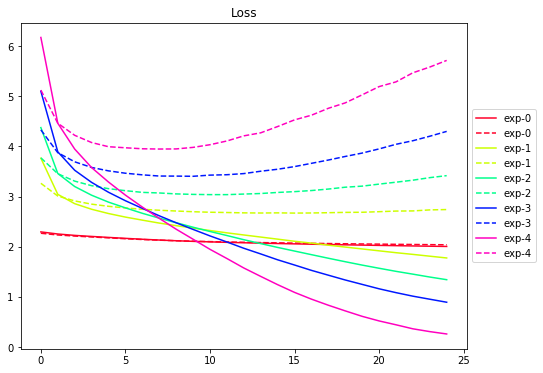

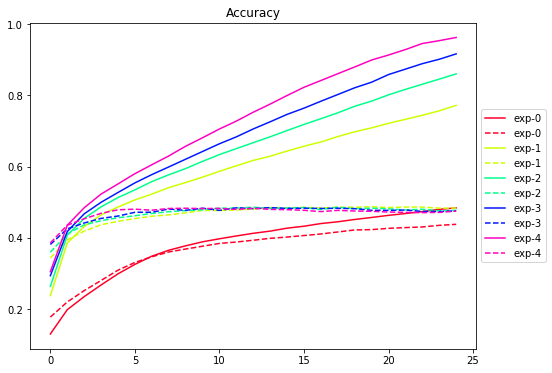

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
cuda.select_device(0)
cuda.close()
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Apr 07 03:30:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 39%   34C    P0    42W / 250W |    295MiB /  4096MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  